In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay


**TRAINING DATASET CLEANING**

In [47]:
training_nfl = pd.read_excel('Training_Data-1.xlsx')

In [48]:
training_nfl.dtypes

DATE                                                                 datetime64[ns]
WEEK#                                                                         int64
PLAY-ID                                                                       int64
DRIVE-ID                                                                      int64
QUARTER                                                                       int64
REMAINING TIME IN THE QUARTER (mm:ss)                                        object
DOWN                                                                        float64
TO GO                                                                         int64
YARD LINE 0-100                                                               int64
OFFENSIVE TEAM                                                               object
DEFENSIVE TEAM                                                               object
OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral                              

In [49]:

# Check for missing values in each column
missing_values = training_nfl.isnull().sum()

# Display columns with missing values
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
DATE                                                                     0
WEEK#                                                                    0
PLAY-ID                                                                  0
DRIVE-ID                                                                 0
QUARTER                                                                  0
REMAINING TIME IN THE QUARTER (mm:ss)                                    0
DOWN                                                                   121
TO GO                                                                    0
YARD LINE 0-100                                                          0
OFFENSIVE TEAM                                                           0
DEFENSIVE TEAM                                                           0
OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral                           0
POINTS SCORED\nBY EITHER TEAM                                        

In [50]:
columns_to_drop = ['POINTS SCORED\nBY EITHER TEAM', 'YARDS GAINED','PLAY-ID','DRIVE-ID','DATE','WEEK#']
training_nfl.drop(columns=columns_to_drop, inplace=True)

In [51]:
# Drop rows with missing values in the 'DOWN' column
training_nfl = training_nfl.dropna(subset=['DOWN'])

# Display the updated dataset
training_nfl.head()

# Optionally check if there are still missing values in the 'DOWN' column
print("Remaining missing values in 'DOWN':", training_nfl['DOWN'].isnull().sum())


Remaining missing values in 'DOWN': 0


In [52]:

# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Identify numerical columns
numerical_columns = training_nfl.select_dtypes(include=['float64', 'int64']).columns

# Check for outliers in all numerical columns
outliers_summary = {}
for column in numerical_columns:
    outliers = detect_outliers_iqr(training_nfl, column)
    outliers_summary[column] = len(outliers)

# Convert the summary into a DataFrame for better visualization
outliers_df = pd.DataFrame(list(outliers_summary.items()), columns=['Column', 'Number of Outliers'])
outliers_df

,Column,Number of Outliers
0,QUARTER,0
1,DOWN,793
2,TO GO,1113
3,YARD LINE 0-100,0
4,ROAD TEAM'S ACCUMULATED SCORE,277
5,HOME TEAM'S ACCUMULATED SCORE,346
6,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...,1756


In [53]:
# Function to handle outliers using capping
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Handle outliers for columns with significant outliers
columns_to_cap = ['SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)',
                  'DOWN', 'HOME TEAM\'S ACCUMULATED SCORE', 'ROAD TEAM\'S ACCUMULATED SCORE','TO GO']

for column in columns_to_cap:
    cap_outliers(training_nfl, column)

# Verify changes by re-checking for outliers
outliers_summary_after = {}
for column in columns_to_cap:
    outliers = detect_outliers_iqr(training_nfl, column)
    outliers_summary_after[column] = len(outliers)
    
outliers_summary_after

{"SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)": 0,
 'DOWN': 0,
 "HOME TEAM'S ACCUMULATED SCORE": 0,
 "ROAD TEAM'S ACCUMULATED SCORE": 0,
 'TO GO': 0}

In [54]:
# Preprocess the time column to ensure all values are strings
training_nfl['REMAINING TIME IN THE QUARTER (mm:ss)'] = training_nfl['REMAINING TIME IN THE QUARTER (mm:ss)'].astype(str)

# Define a function to safely convert to seconds
def safe_time_to_seconds(time_str):
    try:
        # Ensure the string is in 'mm:ss' format and split it
        parts = time_str.split(':')
        minutes = int(parts[0])
        seconds = int(parts[1])
        return minutes * 60 + seconds
    except (ValueError, IndexError):
        return None  # Handle invalid formats gracefully

# Apply the function to convert time to seconds
training_nfl['REMAINING_TIME_SECONDS'] = training_nfl['REMAINING TIME IN THE QUARTER (mm:ss)'].apply(safe_time_to_seconds)

# Drop the original time column if no longer needed
training_nfl.drop(columns=['REMAINING TIME IN THE QUARTER (mm:ss)'], inplace=True)

# Display the updated dataset
training_nfl.head()

,QUARTER,DOWN,TO GO,YARD LINE 0-100,OFFENSIVE TEAM,DEFENSIVE TEAM,"OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral",ROAD TEAM'S ACCUMULATED SCORE,HOME TEAM'S ACCUMULATED SCORE,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score),Play_Type,REMAINING_TIME_SECONDS
0,1,1.0,10.0,75,DET,KC,Road,0.0,0.0,0.0,Run,900
1,1,2.0,3.0,68,DET,KC,Road,0.0,0.0,0.0,Pass,869
2,1,3.0,3.0,68,DET,KC,Road,0.0,0.0,0.0,Pass,865
3,1,1.0,10.0,87,KC,DET,Home,0.0,0.0,0.0,Run,849
4,1,2.0,5.0,82,KC,DET,Home,0.0,0.0,0.0,Run,814


In [55]:
from sklearn.preprocessing import LabelEncoder

# Automatically detect all categorical columns
categorical_columns = training_nfl.select_dtypes(include=['object']).columns

# Exclude 'REMAINING TIME IN THE QUARTER (mm:ss)'
categorical_columns = [col for col in categorical_columns if col != 'REMAINING TIME IN THE QUARTER (mm:ss)']

# Apply LabelEncoder to each remaining categorical column
encoder = LabelEncoder()
for column in categorical_columns:
    training_nfl[column] = encoder.fit_transform(training_nfl[column])


In [56]:


# Manually specify the numerical columns
numerical_columns = ["QUARTER","ROAD TEAM'S ACCUMULATED SCORE",
    "HOME TEAM'S ACCUMULATED SCORE", 'YARD LINE 0-100',
    "SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)",'DOWN','TO GO',
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the manually specified numerical columns
training_nfl[numerical_columns] = scaler.fit_transform(training_nfl[numerical_columns])

# Display the standardized dataset
print(training_nfl.head())


    QUARTER      DOWN     TO GO  YARD LINE 0-100  OFFENSIVE TEAM  \
0 -1.376401 -0.997037  0.472407         0.983369              10   
1 -1.376401  0.231303 -1.493104         0.693837              10   
2 -1.376401  1.459644 -1.493104         0.693837              10   
3 -1.376401 -0.997037  0.472407         1.479709              15   
4 -1.376401  0.231303 -0.931529         1.272901              15   

   DEFENSIVE TEAM  OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral  \
0              15                                               1   
1              15                                               1   
2              15                                               1   
3              10                                               0   
4              10                                               0   

   ROAD TEAM'S ACCUMULATED SCORE  HOME TEAM'S ACCUMULATED SCORE  \
0                      -1.125986                      -1.165969   
1                      -1.125986          

In [57]:
import pandas as pd
import numpy as np

# Feature 1: Game Momentum
# Momentum based on score differential
training_nfl['MOMENTUM'] = training_nfl["HOME TEAM'S ACCUMULATED SCORE"] - training_nfl["ROAD TEAM'S ACCUMULATED SCORE"]

# Feature 2: Time Pressure Index
# Inverse of remaining time to prioritize urgency as time runs out
training_nfl['TIME_PRESSURE'] = 1 / (training_nfl['REMAINING_TIME_SECONDS'].replace(0, 1))

# Feature 4: Team Mismatch
# Difference between offensive and defensive team IDs as a proxy for mismatch
training_nfl['TEAM_MISMATCH'] = np.abs(training_nfl['OFFENSIVE TEAM'] - training_nfl['DEFENSIVE TEAM'])

# View the resulting DataFrame
print(training_nfl[['MOMENTUM', 'TIME_PRESSURE', 'TEAM_MISMATCH']].head())


   MOMENTUM  TIME_PRESSURE  TEAM_MISMATCH
0 -0.039982       0.001111              5
1 -0.039982       0.001151              5
2 -0.039982       0.001156              5
3 -0.039982       0.001178              5
4 -0.039982       0.001229              5


**EDA**

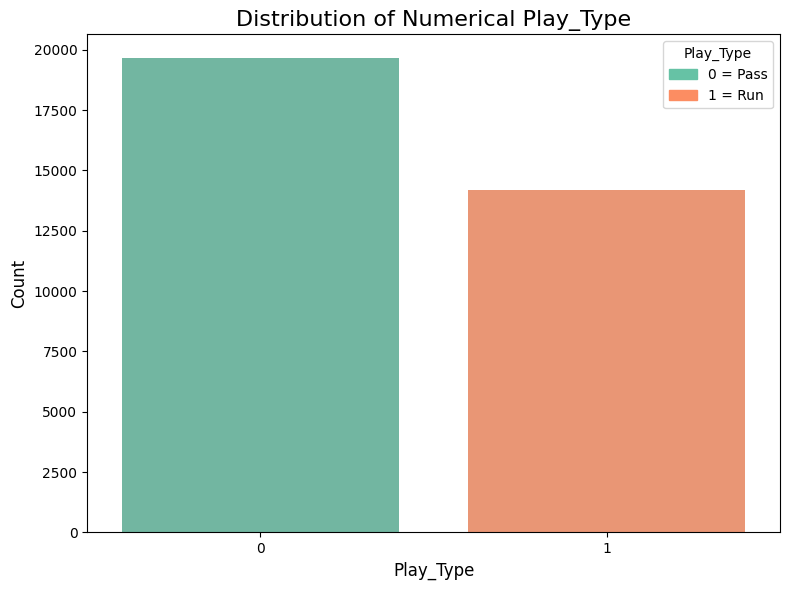

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot distribution of numerical Play_Type with hue
plt.figure(figsize=(8, 6))
sns.countplot(data=training_nfl, x='Play_Type', hue='Play_Type', palette='Set2', dodge=False)

# Add a custom legend to indicate 0 = Pass, 1 = Run
legend_labels = [Patch(color=sns.color_palette('Set2')[0], label='0 = Pass'),
                 Patch(color=sns.color_palette('Set2')[1], label='1 = Run')]
plt.legend(handles=legend_labels, title='Play_Type', loc='upper right')

# Add labels and title
plt.title('Distribution of Numerical Play_Type', fontsize=16)
plt.xlabel('Play_Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


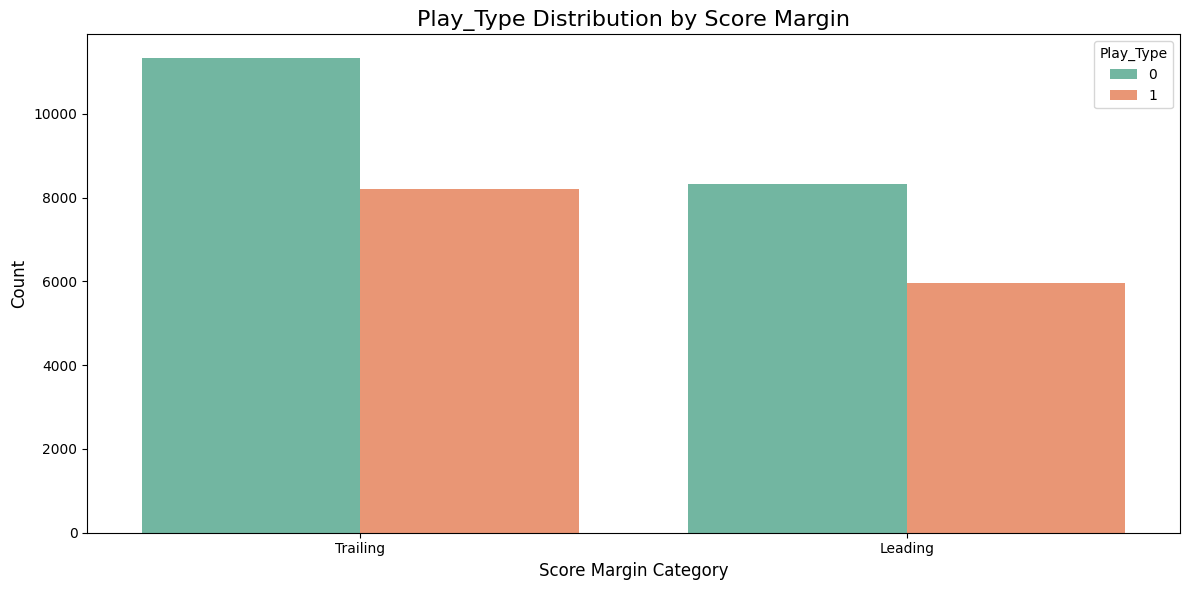

No clear relationship between score margin and Play_Type.


In [60]:


# Hypothesis: Offensive teams trailing in score might favor passing plays to cover ground quickly.

# Define score margin categories locally
score_margin_categories = training_nfl[
    "SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)"
].apply(lambda x: 'Leading' if x > 0 else ('Trailing' if x < 0 else 'Tied'))

# Create a temporary DataFrame for visualization without modifying training_nfl
temp_df = training_nfl.copy()
temp_df['SCORE_MARGIN_CATEGORY'] = score_margin_categories

# Bar chart for Play_Type count by score margin
plt.figure(figsize=(12, 6))
sns.countplot(data=temp_df, x='SCORE_MARGIN_CATEGORY', hue='Play_Type', palette='Set2')
plt.title('Play_Type Distribution by Score Margin', fontsize=16)
plt.xlabel('Score Margin Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Play_Type')
plt.tight_layout()
plt.show()

# Function to conclude based on observations
def conclude_score_margin(data):
    # Map score margin categories locally
    score_margin_categories = data[
        "SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)"
    ].apply(lambda x: 'Leading' if x > 0 else ('Trailing' if x < 0 else 'Tied'))

    # Create a temporary DataFrame for analysis
    temp_df = data.copy()
    temp_df['SCORE_MARGIN_CATEGORY'] = score_margin_categories

    # Check the relationship
    trailing_count = temp_df[temp_df['SCORE_MARGIN_CATEGORY'] == 'Trailing'].groupby('Play_Type').size()
    if 'Pass' in trailing_count.index and trailing_count['Pass'] > trailing_count.get('Run', 0):
        return "Trailing teams favor passing plays."
    else:
        return "No clear relationship between score margin and Play_Type."

# Conclusion for Hypothesis
print(conclude_score_margin(training_nfl))


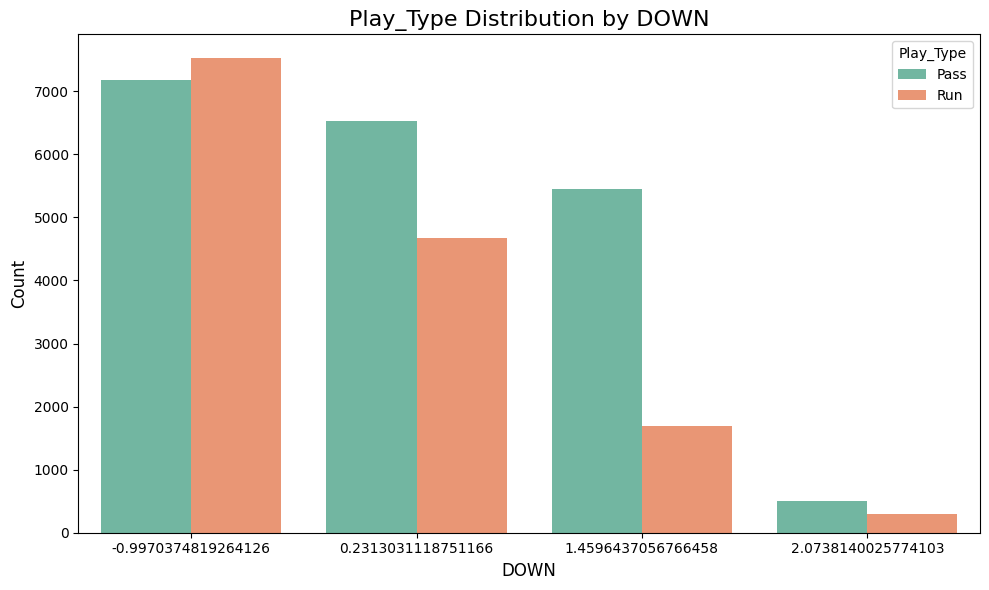

No strong pattern observed between DOWN and Play_Type.


In [61]:


# Define the play type labels locally without modifying training_nfl
play_type_labels = {0: 'Pass', 1: 'Run'}
play_type_labeled = training_nfl['Play_Type'].map(play_type_labels)

# Hypothesis: 
# - Early downs (1st, 2nd) might favor running plays as they are safer and help to establish the drive.
# - Later downs (3rd, 4th) might favor passing plays due to higher pressure to gain yardage.

# Group the data by DOWN and Play_Type_Labeled, then count the occurrences
play_type_counts = training_nfl.groupby(['DOWN', 'Play_Type'])['Play_Type'].count().reset_index(name='Count')
play_type_counts['Play_Type_Labeled'] = play_type_counts['Play_Type'].map(play_type_labels)

# Plot a bar chart to visualize Play_Type distribution across downs
plt.figure(figsize=(10, 6))
sns.barplot(data=play_type_counts, x='DOWN', y='Count', hue='Play_Type_Labeled', palette='Set2')
plt.title('Play_Type Distribution by DOWN', fontsize=16)
plt.xlabel('DOWN', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Play_Type')
plt.tight_layout()
plt.show()

# Conclusion Function
def conclude_down(data):
    # Map play type labels locally
    play_type_labeled = data['Play_Type'].map(play_type_labels)
    
    # Count the occurrences of running and passing plays for each down
    run_counts = play_type_labeled[play_type_labeled == 'Run'].groupby(data['DOWN']).size()
    pass_counts = play_type_labeled[play_type_labeled == 'Pass'].groupby(data['DOWN']).size()
    
    # Draw conclusions based on the max counts for each play type
    if run_counts.idxmax() == 1:
        return "Running plays are most frequent on first downs, suggesting safer strategies early on."
    elif pass_counts.idxmax() in [3, 4]:
        return "Passing plays dominate on later downs, indicating higher pressure situations."
    else:
        return "No strong pattern observed between DOWN and Play_Type."

# Print conclusion
print(conclude_down(training_nfl))


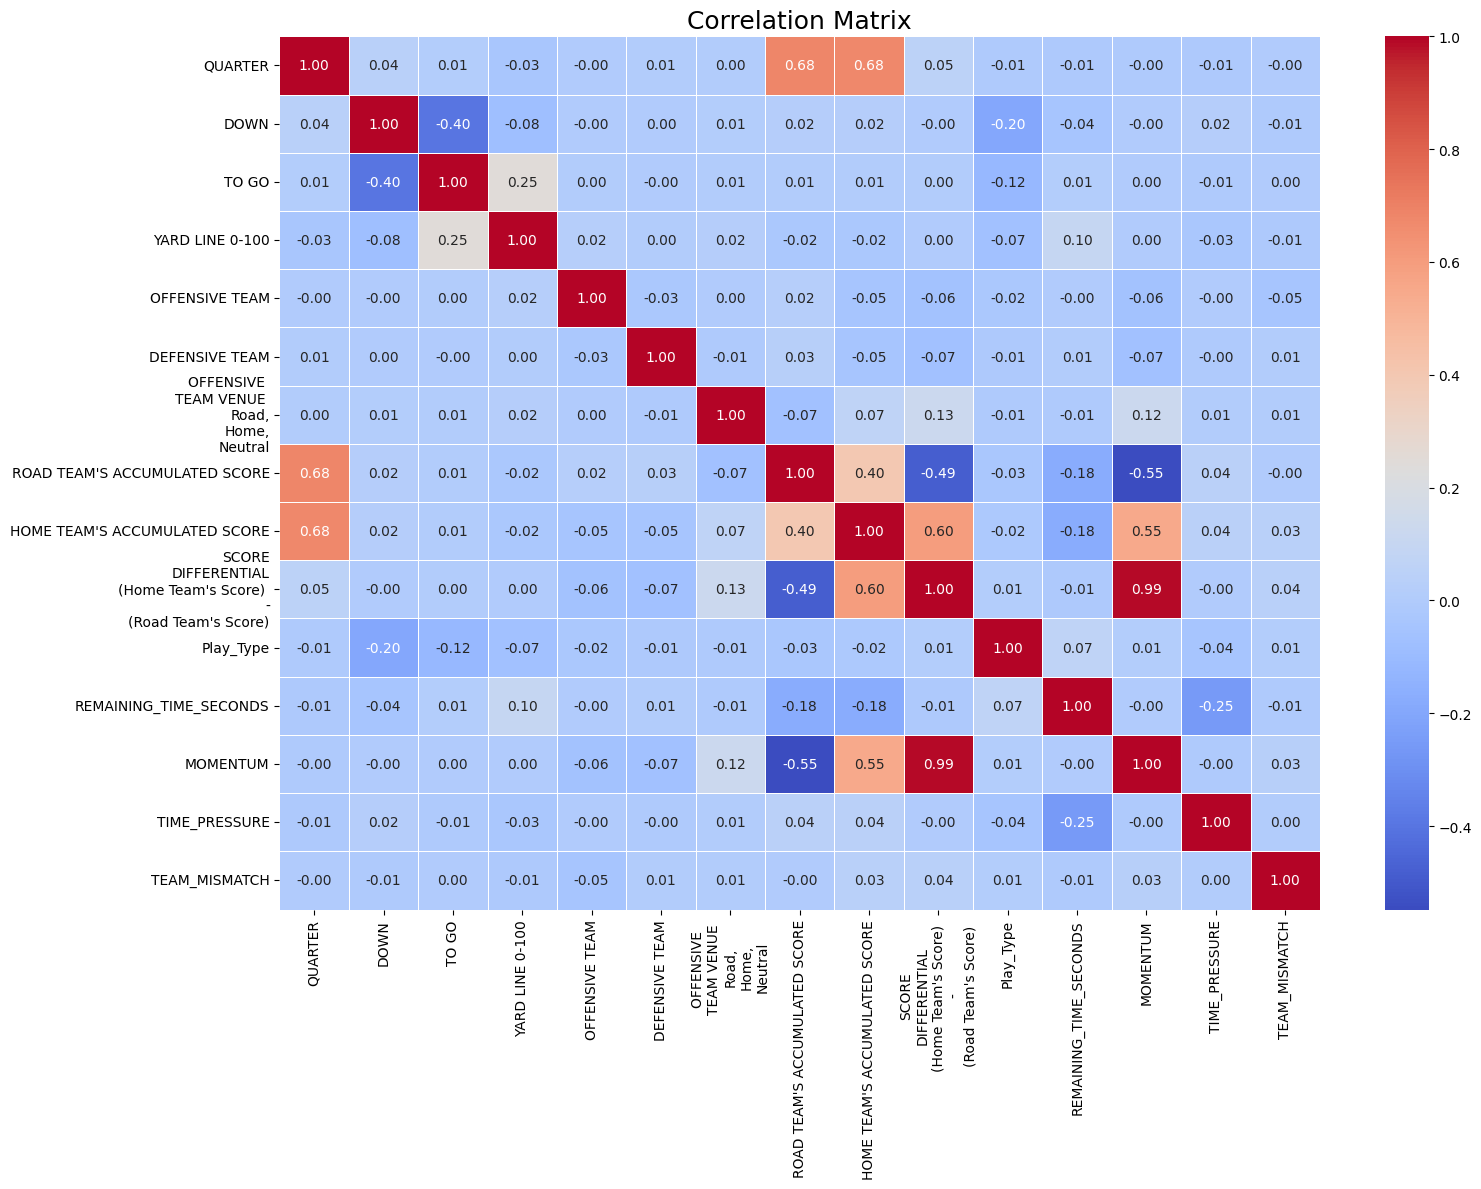

In [62]:


# Ensure only numerical columns are included for correlation
numerical_columns = training_nfl.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Correlation Matrix", fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


**DECISION TREE**

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      5951
           1       0.51      0.53      0.52      4200

    accuracy                           0.59     10151
   macro avg       0.58      0.58      0.58     10151
weighted avg       0.60      0.59      0.59     10151


Accuracy Score:
0.5922569205004433


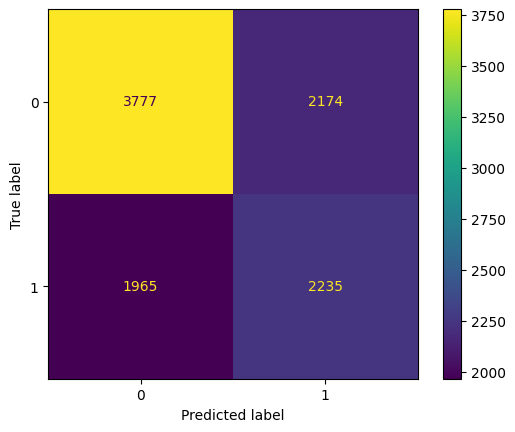

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Features to include
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    'ROAD TEAM\'S ACCUMULATED SCORE', 
    'HOME TEAM\'S ACCUMULATED SCORE',
    'OFFENSIVE TEAM',
    'DEFENSIVE TEAM',
    'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)','REMAINING_TIME_SECONDS',
    'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral','MOMENTUM','TIME_PRESSURE','TEAM_MISMATCH'
]

# Target variable 
target = "Play_Type"

# Splitting dataset into train and test sets
X = training_nfl[features]
y = training_nfl[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred = decision_tree.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(decision_tree, X_test, y_test)


In [65]:
'''from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize the decision tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
}

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=param_grid,
    n_iter=50,  # Test 50 random combinations
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters:", best_params)'''


'from sklearn.tree import DecisionTreeClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\n\n# Initialize the decision tree model\ndecision_tree = DecisionTreeClassifier(random_state=42)\n\n# Define the parameter grid\nparam_grid = {\n    \'criterion\': [\'gini\', \'entropy\'],  # Splitting criterion\n    \'max_depth\': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree\n    \'min_samples_split\': [2, 5, 10],  # Minimum number of samples required to split an internal node\n    \'min_samples_leaf\': [1, 2, 4],  # Minimum number of samples required to be at a leaf node\n    \'max_features\': [\'sqrt\', \'log2\', None],  # Number of features to consider for best split\n}\n\n# Use RandomizedSearchCV for faster hyperparameter tuning\nrandom_search = RandomizedSearchCV(\n    estimator=decision_tree,\n    param_distributions=param_grid,\n    n_iter=50,  # Test 50 random combinations\n    scoring=\'accuracy\',\n    cv=5,  # 5-fold cross-validation\n    verbose=2,\n    rand

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      5951
           1       0.55      0.67      0.60      4200

    accuracy                           0.63     10151
   macro avg       0.64      0.64      0.63     10151
weighted avg       0.65      0.63      0.64     10151


Accuracy Score:
0.6347157915476308


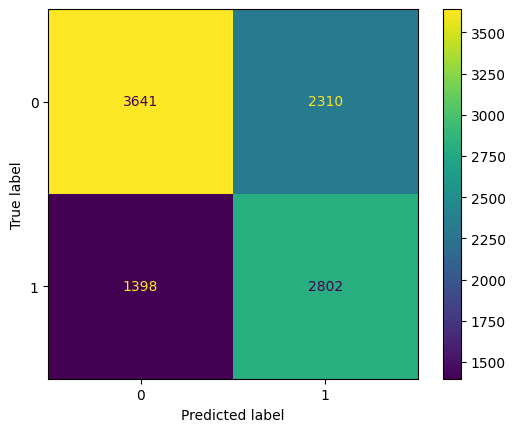

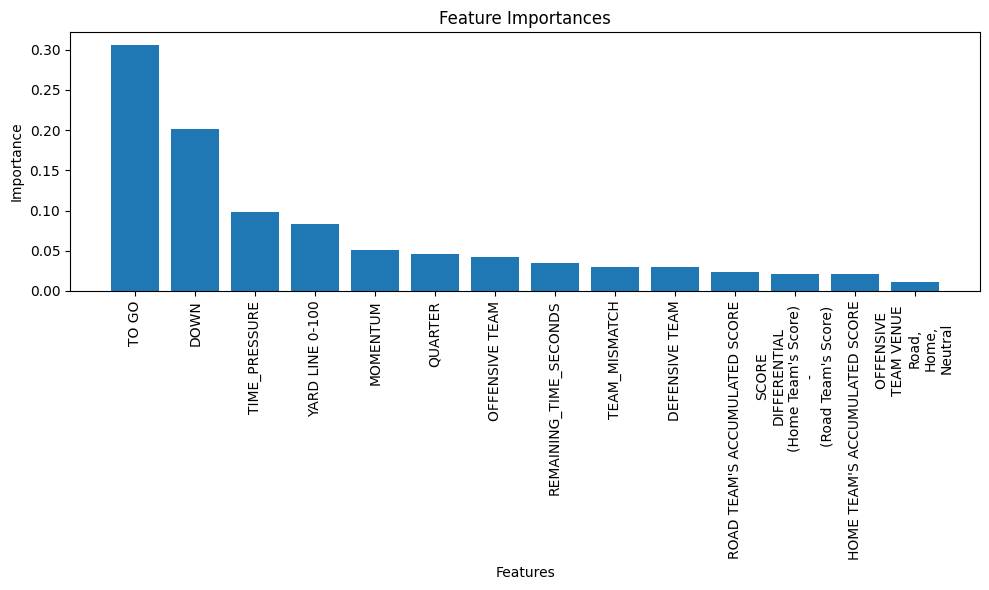

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Create the final model with the best hyperparameters
dtfinal = DecisionTreeClassifier(
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=None,
    max_depth=10,
    criterion='gini',
    random_state=42
)

# Train the model on the training data
dtfinal.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dtfinal.predict(X_test)

# Evaluate the final model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dtfinal, X_test, y_test)
plt.show()

# Feature importance
feature_importances = dtfinal.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), np.array(X_train.columns)[sorted_indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

**RANDOM FOREST**

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      5951
           1       0.59      0.53      0.56      4200

    accuracy                           0.66     10151
   macro avg       0.64      0.64      0.64     10151
weighted avg       0.65      0.66      0.65     10151


Accuracy Score:
0.6558959708403113


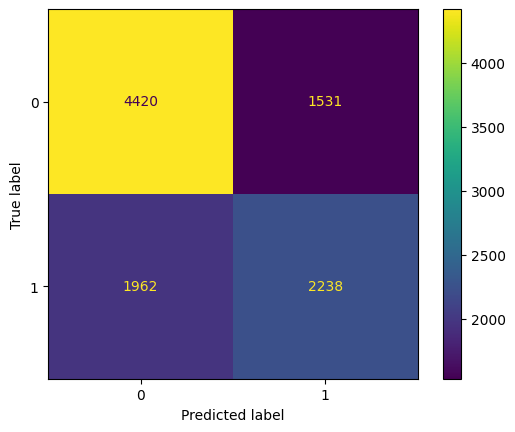

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Features and target
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    'ROAD TEAM\'S ACCUMULATED SCORE', 
    'HOME TEAM\'S ACCUMULATED SCORE',
    'OFFENSIVE TEAM',
    'DEFENSIVE TEAM',
    'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)','REMAINING_TIME_SECONDS',
    'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral','MOMENTUM','TIME_PRESSURE','TEAM_MISMATCH'
]

target = "Play_Type"

# Train-Test Split
X = training_nfl[features]
y = training_nfl[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)


In [69]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],       # Number of trees
    'max_depth': [10, 20, 30, None],               # Maximum depth of each tree
    'min_samples_split': [2, 5, 10, 20],           # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4, 8],              # Minimum number of samples at a leaf node
    'max_features': ['sqrt', 'log2', None]         # Number of features to consider for split
}

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,              # Number of random combinations to test
    scoring='accuracy',     # Evaluation metric
    cv=5,                   # 5-fold cross-validation
    verbose=2,              # Display detailed progress
    random_state=42,        # Reproducibility
    n_jobs=-1               # Use all available cores
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params_rf = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters:", best_params_rf)'''


'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\n\n# Define the parameter grid for RandomizedSearchCV\nparam_grid = {\n    \'n_estimators\': [50, 100, 200, 300, 500],       # Number of trees\n    \'max_depth\': [10, 20, 30, None],               # Maximum depth of each tree\n    \'min_samples_split\': [2, 5, 10, 20],           # Minimum number of samples to split a node\n    \'min_samples_leaf\': [1, 2, 4, 8],              # Minimum number of samples at a leaf node\n    \'max_features\': [\'sqrt\', \'log2\', None]         # Number of features to consider for split\n}\n\n# Initialize Random Forest Classifier\nrf_model = RandomForestClassifier(random_state=42)\n\n# Use RandomizedSearchCV for faster hyperparameter tuning\nrandom_search = RandomizedSearchCV(\n    estimator=rf_model,\n    param_distributions=param_grid,\n    n_iter=50,              # Number of random combinations to test\n    scoring=\'accuracy\',     # Evaluation 


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      5951
           1       0.60      0.57      0.58      4200

    accuracy                           0.66     10151
   macro avg       0.65      0.65      0.65     10151
weighted avg       0.66      0.66      0.66     10151


Accuracy Score:
0.6615111811644173


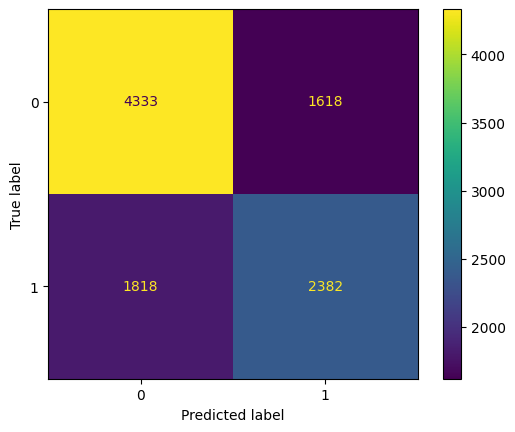

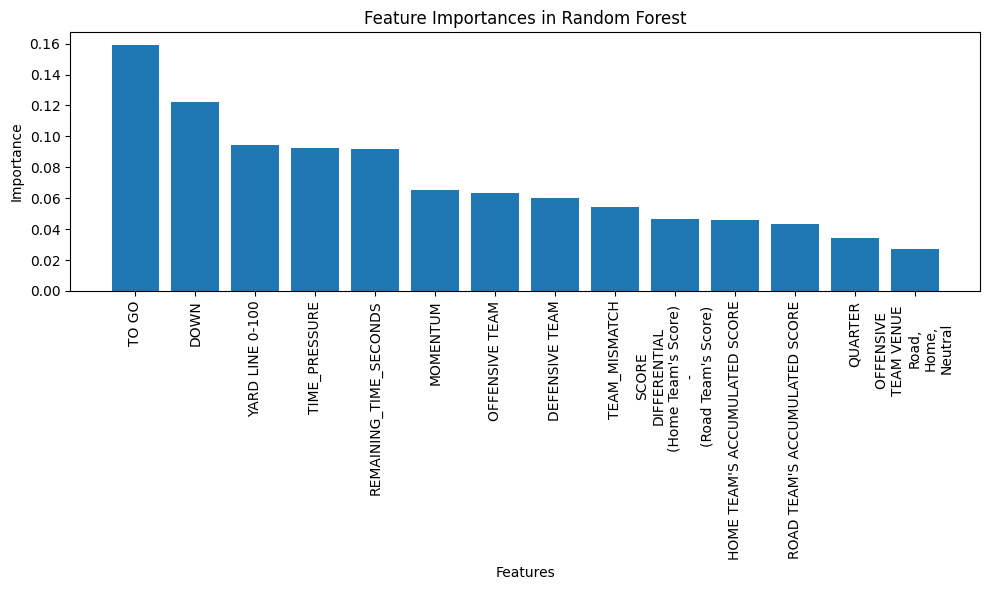

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Train the Random Forest with the best hyperparameters and n_estimators=100
rf_final = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    min_samples_split=20,       # Best hyperparameter from tuning
    min_samples_leaf=7,         # Best hyperparameter from tuning
    max_features='sqrt',        # Best hyperparameter from tuning
    max_depth=20,               # Best hyperparameter from tuning
    criterion='entropy',        # Best hyperparameter from tuning
    random_state=42,            # For reproducibility
    oob_score=True
)

# Fit the model on the training data
rf_final.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_final.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_final, X_test, y_test)
plt.show()

# Feature importance
feature_importances = rf_final.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), np.array(X_train.columns)[sorted_indices], rotation=90)
plt.title("Feature Importances in Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


**Gradient boosting**

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      5951
           1       0.59      0.58      0.59      4200

    accuracy                           0.66     10151
   macro avg       0.65      0.65      0.65     10151
weighted avg       0.66      0.66      0.66     10151


Accuracy Score:
0.6618067185498966


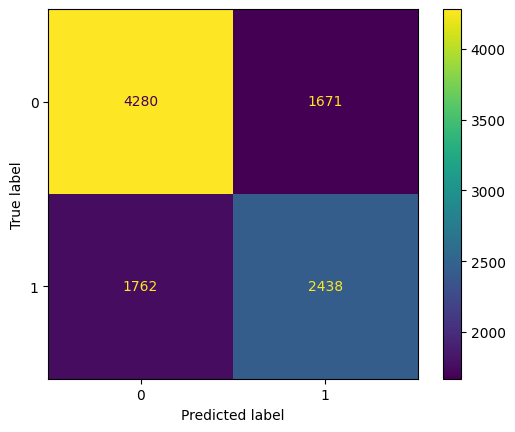

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Features and target
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    'ROAD TEAM\'S ACCUMULATED SCORE', 
    'HOME TEAM\'S ACCUMULATED SCORE',
    'OFFENSIVE TEAM',
    'DEFENSIVE TEAM',
    'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)','REMAINING_TIME_SECONDS',
    'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral','MOMENTUM','TIME_PRESSURE','TEAM_MISMATCH'
]
target = "Play_Type"

# Train-Test Split
X = training_nfl[features]
y = training_nfl[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Gradient Boosting model with default parameters
gb_model = GradientBoostingClassifier(random_state=42)  # For reproducibility

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(gb_model, X_test, y_test)


In [73]:
'''from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Parameter grid for GradientBoostingClassifier
param_grid = {
    'n_estimators': [50, 100, 200, 500],            # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2, 0.3],         # Learning rate (shrinkage)
    'max_depth': [3, 5, 7, 10],                     # Maximum depth of trees
    'min_samples_split': [2, 5, 10,20],                # Minimum number of samples required to split
    'min_samples_leaf': [1, 2, 4],                  # Minimum number of samples per leaf
    'subsample': [0.6, 0.8, 1.0]                    # Fraction of samples used for training each tree
}

# Initialize GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_grid,
    n_iter=50,               # Number of combinations to test
    scoring='accuracy',      # Optimization metric
    cv=5,                    # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                # Use all available cores
)

# Fit the randomized search model
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params_gb = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params_gb)'''


'from sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import classification_report, accuracy_score\n\n# Parameter grid for GradientBoostingClassifier\nparam_grid = {\n    \'n_estimators\': [50, 100, 200, 500],            # Number of boosting stages\n    \'learning_rate\': [0.01, 0.1, 0.2, 0.3],         # Learning rate (shrinkage)\n    \'max_depth\': [3, 5, 7, 10],                     # Maximum depth of trees\n    \'min_samples_split\': [2, 5, 10,20],                # Minimum number of samples required to split\n    \'min_samples_leaf\': [1, 2, 4],                  # Minimum number of samples per leaf\n    \'subsample\': [0.6, 0.8, 1.0]                    # Fraction of samples used for training each tree\n}\n\n# Initialize GradientBoostingClassifier\ngb_model = GradientBoostingClassifier(random_state=42)\n\n# RandomizedSearchCV for hyperparameter tuning\nrandom_search = RandomizedSearchCV(\n    estimator=gb

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      5951
           1       0.60      0.58      0.59      4200

    accuracy                           0.66     10151
   macro avg       0.65      0.65      0.65     10151
weighted avg       0.66      0.66      0.66     10151


Accuracy Score:
0.6647620924046892


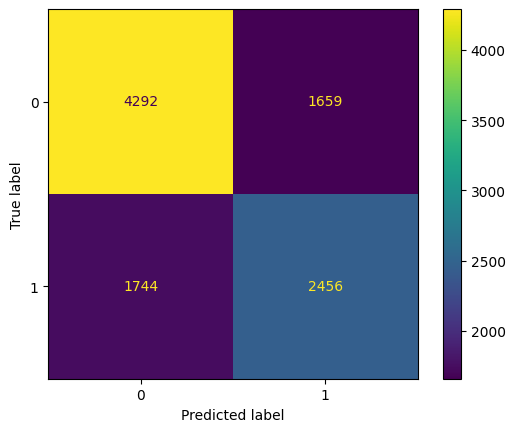

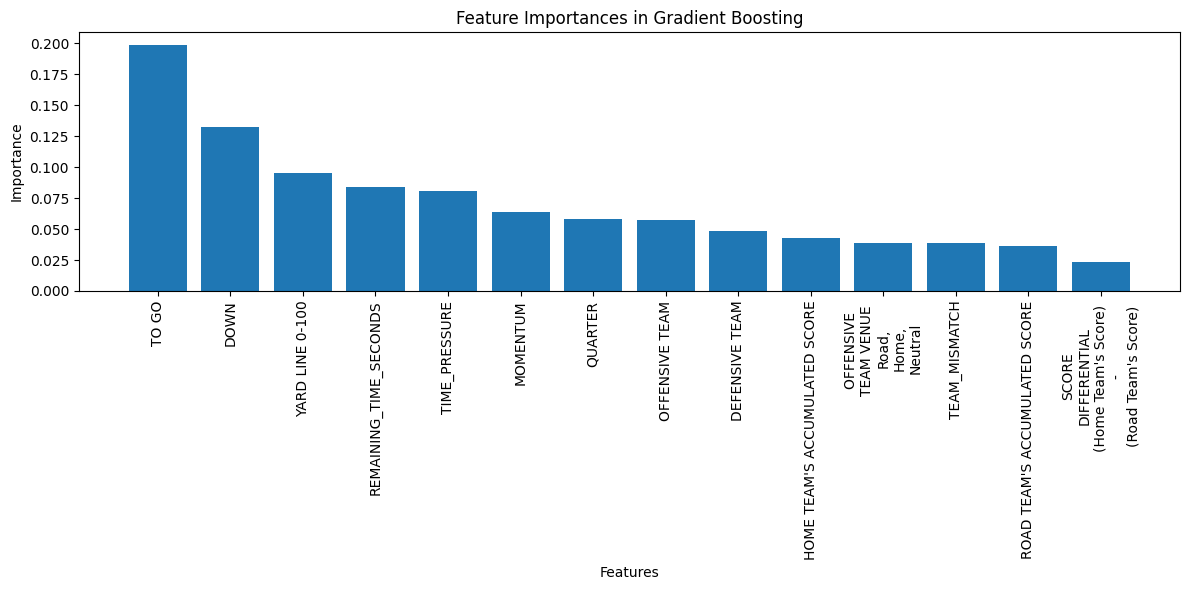

In [131]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Features and target
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    'ROAD TEAM\'S ACCUMULATED SCORE', 
    'HOME TEAM\'S ACCUMULATED SCORE',
    'OFFENSIVE TEAM',
    'DEFENSIVE TEAM',
    'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)','REMAINING_TIME_SECONDS',
    'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral','MOMENTUM','TIME_PRESSURE','TEAM_MISMATCH'
]
target = "Play_Type"

# Train-Test Split
X = training_nfl[features]
y = training_nfl[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages
    learning_rate=0.1, # Learning rate (shrinkage factor)
    max_depth=7,       # Maximum depth of the individual estimators
    random_state=42    # For reproducibility
)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(gb_model, X_test, y_test)
plt.show()

# Feature Importance
feature_importances = gb_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), np.array(features)[sorted_indices], rotation=90)
plt.title("Feature Importances in Gradient Boosting")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


**TESTING**

In [133]:
testing_nfl = pd.read_excel('Test_Data.xlsx')

In [134]:
testing_nfl.dtypes

DATE                                                                     datetime64[ns]
WEEK#                                                                             int64
ROAD TEAM                                                                        object
HOME TEAM                                                                        object
PLAY-ID                                                                           int64
DRIVE-ID                                                                          int64
QUARTER                                                                           int64
REMAINING TIME IN THE QUARTER (mm:ss)                                            object
DOWN                                                                            float64
TO GO                                                                             int64
YARD LINE 0-100                                                                   int64
OFFENSIVE TEAM                  

In [135]:

# Check for missing values in each column
missing_values = testing_nfl.isnull().sum()

# Display columns with missing values
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
DATE                                                                        0
WEEK#                                                                       0
ROAD TEAM                                                                   0
HOME TEAM                                                                   0
PLAY-ID                                                                     0
DRIVE-ID                                                                    0
QUARTER                                                                     0
REMAINING TIME IN THE QUARTER (mm:ss)                                       0
DOWN                                                                        5
TO GO                                                                       0
YARD LINE 0-100                                                             0
OFFENSIVE TEAM                                                              0
DEFENSIVE TEAM                   

In [136]:
columns_to_drop = [
    'POINTS SCORED\nBY EITHER TEAM', 
    'ROAD TEAM',
    'DATE',
    'WEEK#',
    'PLAY-ID',
    'DRIVE-ID',
    'HOME TEAM',
    'YARDS GAINED',
    'PASS OUTCOME Complete,\nIncomplete,\nSack',
    'PASS LENGTH Short,\nDeep',
    'PASS LOCATION Left,\nMiddle,\nRight',
    'AIR YARDS',
    'YARDS AFTER CATCH \n(YAC)',
    'RUN LOCATION Left,\nMiddle,\nRight',
    'TOUCHDOWN Pass/Offensive TD,\nRush/Offensive TD,\nReturn/Defensive TD'
]
testing_nfl.drop(columns=columns_to_drop, inplace=True)

In [137]:
# Drop rows with missing values in the 'DOWN' column
testing_nfl = testing_nfl.dropna(subset=['DOWN'])

# Display the updated dataset
testing_nfl.head()

# Optionally check if there are still missing values in the 'DOWN' column
print("Remaining missing values in 'DOWN':", testing_nfl['DOWN'].isnull().sum())


Remaining missing values in 'DOWN': 0


In [138]:

# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Identify numerical columns
numerical_columns = testing_nfl.select_dtypes(include=['float64', 'int64']).columns

# Check for outliers in all numerical columns
outliers_summary = {}
for column in numerical_columns:
    outliers = detect_outliers_iqr(testing_nfl, column)
    outliers_summary[column] = len(outliers)

# Convert the summary into a DataFrame for better visualization
outliers_df = pd.DataFrame(list(outliers_summary.items()), columns=['Column', 'Number of Outliers'])
outliers_df

,Column,Number of Outliers
0,QUARTER,0
1,DOWN,40
2,TO GO,41
3,YARD LINE 0-100,0
4,ROAD TEAM'S ACCUMULATED SCORE,46
5,HOME TEAM'S ACCUMULATED SCORE,0
6,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...,124


In [139]:
# Function to handle outliers using capping
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Handle outliers for columns with significant outliers
columns_to_cap = ['SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)',
                  'DOWN', 'HOME TEAM\'S ACCUMULATED SCORE', 'ROAD TEAM\'S ACCUMULATED SCORE','TO GO']

for column in columns_to_cap:
    cap_outliers(testing_nfl, column)

# Verify changes by re-checking for outliers
outliers_summary_after = {}
for column in columns_to_cap:
    outliers = detect_outliers_iqr(testing_nfl, column)
    outliers_summary_after[column] = len(outliers)
    
outliers_summary_after

{"SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)": 0,
 'DOWN': 0,
 "HOME TEAM'S ACCUMULATED SCORE": 0,
 "ROAD TEAM'S ACCUMULATED SCORE": 0,
 'TO GO': 0}

In [140]:
# Preprocess the time column to ensure all values are strings
testing_nfl['REMAINING TIME IN THE QUARTER (mm:ss)'] = testing_nfl['REMAINING TIME IN THE QUARTER (mm:ss)'].astype(str)

# Define a function to safely convert to seconds
def safe_time_to_seconds(time_str):
    try:
        # Ensure the string is in 'mm:ss' format and split it
        parts = time_str.split(':')
        minutes = int(parts[0])
        seconds = int(parts[1])
        return minutes * 60 + seconds
    except (ValueError, IndexError):
        return None  # Handle invalid formats gracefully

# Apply the function to convert time to seconds
testing_nfl['REMAINING_TIME_SECONDS'] = testing_nfl['REMAINING TIME IN THE QUARTER (mm:ss)'].apply(safe_time_to_seconds)

# Drop the original time column if no longer needed
testing_nfl.drop(columns=['REMAINING TIME IN THE QUARTER (mm:ss)'], inplace=True)

# Display the updated dataset
testing_nfl.head()

,QUARTER,DOWN,TO GO,YARD LINE 0-100,OFFENSIVE TEAM,DEFENSIVE TEAM,"OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral",ROAD TEAM'S ACCUMULATED SCORE,HOME TEAM'S ACCUMULATED SCORE,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score),Play_Type,REMAINING_TIME_SECONDS
0,1,1.0,10.0,75,CLE,HOU,Road,0.0,0.0,0.0,Pass,900
1,1,1.0,10.0,64,CLE,HOU,Road,0.0,0.0,0.0,Pass,877
2,1,2.0,5.0,59,CLE,HOU,Road,0.0,0.0,0.0,Run,839
3,1,3.0,9.0,63,CLE,HOU,Road,0.0,0.0,0.0,Pass,797
4,1,1.0,10.0,83,HOU,CLE,Home,0.0,0.0,0.0,Pass,745


In [141]:
from sklearn.preprocessing import LabelEncoder

# Automatically detect all categorical columns
categorical_columns = testing_nfl.select_dtypes(include=['object']).columns

# Exclude 'REMAINING TIME IN THE QUARTER (mm:ss)'
categorical_columns = [col for col in categorical_columns if col != 'REMAINING TIME IN THE QUARTER (mm:ss)']

# Apply LabelEncoder to each remaining categorical column
encoder = LabelEncoder()
for column in categorical_columns:
    testing_nfl[column] = encoder.fit_transform(testing_nfl[column])


In [142]:


# Manually specify the numerical columns
numerical_columns = ["QUARTER","ROAD TEAM'S ACCUMULATED SCORE",
    "HOME TEAM'S ACCUMULATED SCORE", 'YARD LINE 0-100',
    "SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)",'DOWN','TO GO',
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the manually specified numerical columns
testing_nfl[numerical_columns] = scaler.fit_transform(testing_nfl[numerical_columns])

# Display the standardized dataset
print(testing_nfl.head())


    QUARTER      DOWN     TO GO  YARD LINE 0-100  OFFENSIVE TEAM  \
0 -1.370978 -0.970703  0.494848         1.052239               2   
1 -1.370978 -0.970703  0.494848         0.588880               2   
2 -1.370978  0.270524 -0.947945         0.378263               2   
3 -1.370978  1.511750  0.206290         0.546757               2   
4 -1.370978 -0.970703  0.494848         1.389227               6   

   DEFENSIVE TEAM  OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral  \
0               6                                               1   
1               6                                               1   
2               6                                               1   
3               6                                               1   
4               2                                               0   

   ROAD TEAM'S ACCUMULATED SCORE  HOME TEAM'S ACCUMULATED SCORE  \
0                      -1.218379                      -1.247789   
1                      -1.218379          

In [143]:
import pandas as pd
import numpy as np

# Feature 1: Game Momentum
# Momentum based on score differential
testing_nfl['MOMENTUM'] = testing_nfl["HOME TEAM'S ACCUMULATED SCORE"] - testing_nfl["ROAD TEAM'S ACCUMULATED SCORE"]

# Feature 2: Time Pressure Index
# Inverse of remaining time to prioritize urgency as time runs out
testing_nfl['TIME_PRESSURE'] = 1 / (testing_nfl['REMAINING_TIME_SECONDS'].replace(0, 1))

# Feature 4: Team Mismatch
# Difference between offensive and defensive team IDs as a proxy for mismatch
testing_nfl['TEAM_MISMATCH'] = np.abs(testing_nfl['OFFENSIVE TEAM'] - testing_nfl['DEFENSIVE TEAM'])


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       986
           1       0.57      0.65      0.61       652

    accuracy                           0.66      1638
   macro avg       0.66      0.66      0.66      1638
weighted avg       0.68      0.66      0.67      1638


Accuracy Score:
0.6648351648351648
Results saved to test_results.csv
   Actual  Predicted
0       1          0
1       1          0
2       0          0
3       0          0
4       0          0


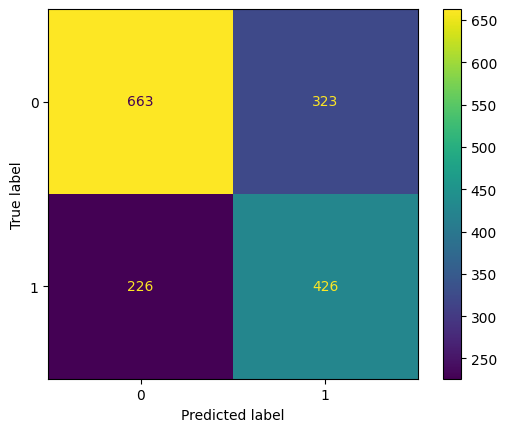

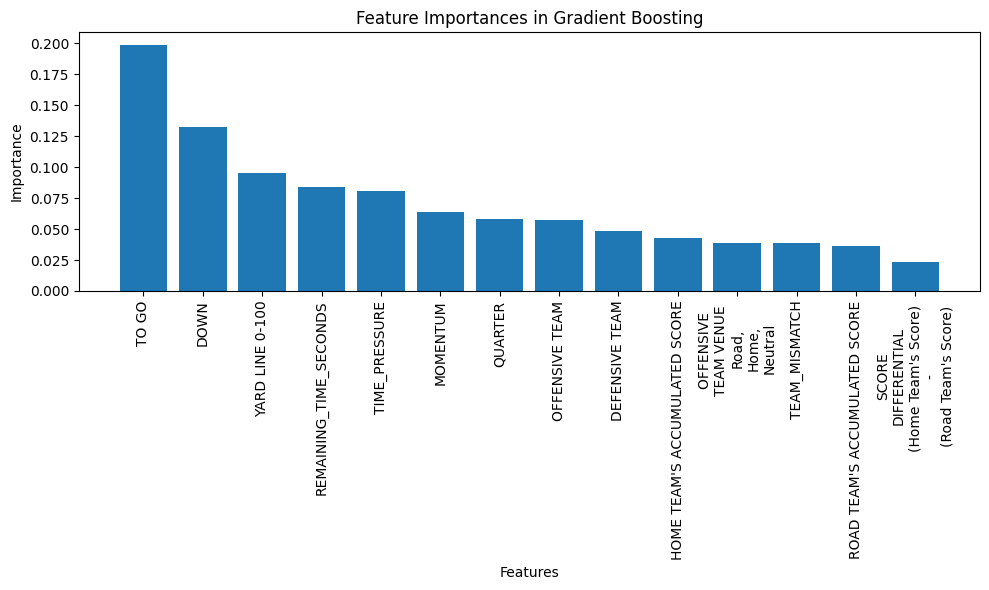

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Features used for training
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    'ROAD TEAM\'S ACCUMULATED SCORE', 
    'HOME TEAM\'S ACCUMULATED SCORE',
    'OFFENSIVE TEAM',
    'DEFENSIVE TEAM',
    'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)','REMAINING_TIME_SECONDS',
    'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral','MOMENTUM','TIME_PRESSURE','TEAM_MISMATCH'
]

# Extract features from the testing dataset
X_test_new = testing_nfl[features]

# Use the trained model to predict
y_pred_new = gb_model.predict(X_test_new)
y_test_new = testing_nfl['Play_Type']

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_new, y_pred_new))

print("\nAccuracy Score:")
print(accuracy_score(y_test_new, y_pred_new))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_new, y_pred_new)
plt.show()

# Feature importance
feature_importances = gb_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), np.array(features)[sorted_indices], rotation=90)
plt.title("Feature Importances in Gradient Boosting")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [175]:
import pandas as pd

results = pd.DataFrame({
    'Actual': y_test_new,
    'Predicted': y_pred_new
})

# Save the results to a CSV file
output_path = "test_results.csv"
results.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Read the saved CSV to verify the contents
saved_results = pd.read_csv(output_path)
print(saved_results.head())


Results saved to test_results.csv
   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       0          0
4       0          0
